<h1> Google Analytics Customer Revenue Prediction

<h2> Data Source</h2>

https://www.kaggle.com/c/ga-customer-revenue-prediction/data

<h2> What am I predicting?</h2>

I'm predicting the natural log of the sum of all transactions per user.

Note that the dataset does NOT contain data for December 1st 2018 to January 31st 2019. You must identify the unique fullVisitorIds in the provided test_v2.csv and make predictions for them for those unseen months.

<h2>File Descriptions</h2>

1. <b>train.csv -</b> the updated training set - contains user transactions from August 1st 2016 to April 30th 2018.
2. <b>test.csv -</b> the updated test set - contains user transactions from May 1st 2018 to October 15th 2018.
3. <b>sample_submission_v2.csv -</b> a updated sample submission file in the correct format. Contains all fullVisitorIds in test_v2.csv. Your submission's PredictedLogRevenue column should make forward-looking predictions for each of these fullVisitorIds for the timeframe of December 1st 2018 to January 31st 2019. Review "What am I predicting?" above for details.

<h2>Data Fields</h2>

1. <b>fullVisitorId- </b>A unique identifier for each user of the Google Merchandise Store.
2. <b>channelGrouping - </b>The channel via which the user came to the Store.
3. <b>date - </b>The date on which the user visited the Store.
4. <b>device - </b>The specifications for the device used to access the Store.
5. <b>geoNetwork - </b>This section contains information about the geography of the user.
6. <b>socialEngagementType - </b>Engagement type, either "Socially Engaged" or "Not Socially Engaged".
7. <b>totals - </b>This section contains aggregate values across the session.
8. <b>trafficSource - </b>This section contains information about the Traffic Source from which the session originated.
9. <b>visitId -</b> An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
10. <b>visitNumber - </b>The session number for this user. If this is the first session, then this is set to 1.
11. <b>visitStartTime -</b> The timestamp (expressed as POSIX time).
12. <b>hits -</b> This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
13. <b>customDimensions - </b>This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.

<h2>Data Size </h2>

A total of 1.7 million entries are given as data in the form of train and test dataset.

1. Train dataset - 903653 rows
2. Test dataset - 804684 rows

<h2> To Note -</h2>

1. Due to the formatting of fullVisitorId I must load the Id's as strings in order for all Id's to be properly unique!
2. There are multiple columns which contain JSON blobs of varying depth. In one of those JSON columns, totals, the sub-column <b>transactionRevenue</b> contains the revenue information we are trying to predict. This sub-column exists only for the training data.

<h2> Loading libraries</h2>

In [1]:
import pandas as pd
import numpy as np

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<h2> Loading dataset </h2>

<b> Columns with JSON data-</b>
    1. device
    2. geoNetwork
    3. totals
    4. trafficSource
<b>These columns has to be flattened out.</b>
    
<H3> Converting columns with JSON data into features</H3>

<b> Procedure-</b>
    1. load these columns as json type
    2. Then apply json_normalize() on these columns. We'll get all the sub-columns in the form of dataframe
    3. Remove the json column and add the sub-columns into the main dataframe
    

In [2]:
import json
from pandas.io.json import json_normalize

In [3]:
#CITATION: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook

def load_flatten_df(path, nrows=None):
    """
    Rads the CSV data and flattens the JSON fields.
    
    """ 
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    #reading the csv file
    df = pd.read_csv(path, 
                     converters={column: json.loads for column in json_columns}, #Decoding JSON, loading those col as json dtype
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in json_columns:  #i.e. for all columns that are in json format
        column_as_df = json_normalize(df[column]) #convert the json string into a smaller dataframe with all sub-columns
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] #adding column name to all the sub-column
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True) 
        #axis=1 means i'm removing the json 'column' from train dataset 
        #and merging the sub-columns into train dataset
    
    return df

In [11]:
from datetime import datetime

In [12]:
start = pd.datetime.now().minute

train = load_flatten_df("train.csv")

print("Time taken:", pd.datetime.now().minute- start)

Time taken: 2


In [13]:
start = pd.datetime.now().minute

test = load_flatten_df("test.csv")

print("Time taken:", pd.datetime.now().minute- start)

Time taken: 4


In [3]:
sample_submission= pd.read_csv("sample_submission.csv")

In [15]:
#############
train1=train
test1= test

In [318]:
print("Shape of train dataset:", train.shape)
print("Shape of test dataset:",test.shape)
print("Shape of sample_submission dataset:",sample_submission.shape)

Shape of train dataset: (903653, 55)
Shape of test dataset: (804684, 53)
Shape of sample_submission dataset: (617242, 2)


<h2> Looking at the dataset</h2>

In [319]:
train.head(2)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:
1. visitId and visitStartTime are same
2. sessionId = fullVisitorId_visitId/ fullVisitorId_visitStartTime

In [320]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.t

In [321]:
test.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.newVisits', 'totals.bounces',
       'trafficS

    2 columns- 
    1. totals.transactionRevenue
    2. trafficSource.campaignCode
    
    are present in train but not in test dataset

In [322]:
train.describe()

,date,visitId,visitNumber,visitStartTime
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09


In [21]:
#checking no.of unique elements in each column
n = train.nunique()   #nunique()- gives no.of unique elments
n

channelGrouping                                           8
date                                                    366
fullVisitorId                                        714167
sessionId                                            902755
socialEngagementType                                      1
visitId                                              886303
visitNumber                                             384
visitStartTime                                       887159
device.browser                                           54
device.browserVersion                                     1
device.browserSize                                        1
device.operatingSystem                                   20
device.operatingSystemVersion                             1
device.isMobile                                           2
device.mobileDeviceBranding                               1
device.mobileDeviceModel                                  1
device.mobileInputSelector              

<b> Here I can see that many features have only 1 unique element. 

In [22]:
count=0
for i in n:
    if i==1: #i.e if #unique elements=1
        count+=1
print("no. of columns with same components in each row:", count)

no. of columns with same components in each row: 24


<b>Let's check what is the one 'unique' element in each row by randomly picking few columns with 1 unique element

In [23]:
#1)
train['device.operatingSystemVersion']

0         not available in demo dataset
1         not available in demo dataset
2         not available in demo dataset
3         not available in demo dataset
4         not available in demo dataset
                      ...              
903648    not available in demo dataset
903649    not available in demo dataset
903650    not available in demo dataset
903651    not available in demo dataset
903652    not available in demo dataset
Name: device.operatingSystemVersion, Length: 903653, dtype: object

In [24]:
#2)
train['totals.visits']

0         1
1         1
2         1
3         1
4         1
         ..
903648    1
903649    1
903650    1
903651    1
903652    1
Name: totals.visits, Length: 903653, dtype: object

In [25]:
#3)
train['trafficSource.adwordsClickInfo.isVideoAd']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
903648    NaN
903649    NaN
903650    NaN
903651    NaN
903652    NaN
Name: trafficSource.adwordsClickInfo.isVideoAd, Length: 903653, dtype: object

In [26]:
#4)
train['socialEngagementType']

0         Not Socially Engaged
1         Not Socially Engaged
2         Not Socially Engaged
3         Not Socially Engaged
4         Not Socially Engaged
                  ...         
903648    Not Socially Engaged
903649    Not Socially Engaged
903650    Not Socially Engaged
903651    Not Socially Engaged
903652    Not Socially Engaged
Name: socialEngagementType, Length: 903653, dtype: object

<b>After looking at the above features it's clear that these features won't benefit in any way. So it's better to remove these features.



In [27]:
#Preparing a list of columns with unique elements=1
col_to_remove_train=[]
for col in train.columns:
    if train[col].nunique()==1:
        col_to_remove_train.append(col)

In [28]:
col_to_remove_train #these features can be dropped

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']

<b>Before dropping these features, it's best to check if the situation is same in test dataset too.  

In [29]:
#Preparing a list of columns with unique elements=1
col_to_remove_test=[]
for col in test.columns:
    if test[col].nunique()==1:
        col_to_remove_test.append(col)
print(col_to_remove_test)

print("no. of columns with same components in each row:", len(col_to_remove_test))

['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'totals.newVisits', 'totals.bounces', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.isVideoAd']
no. of columns with same components in each row: 23


<b>The test dataset does not contain 'trafficSource.campaignCode' feature. Rest 23 features are same and we can remove these columns from both both train and test dataset


In [323]:
print("Size of train before: ", train.shape)
train = train.drop(col_to_remove_train,axis =1)
print("Size of train after: ", train.shape)

print("Size of test before: ", test.shape)
test = test.drop(col_to_remove_test,axis =1)
print("Size of test after: ", test.shape)

Size of train before:  (903653, 55)
Size of train after:  (903653, 31)
Size of test before:  (804684, 53)
Size of test after:  (804684, 30)


In [324]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adContent'],
      dtype='object')

<h2>Handling date feature

In [325]:
print("A sample date format now:",train.date[0])
print(type(train.date[0])) #type-int

A sample date format now: 20160902
<class 'numpy.int64'>


<b> So this is in the form yyyymmdd

In [333]:
from datetime import datetime

In [327]:
#sample cell

#experimenting with the'date' value
a=train.date[0] #taking sample

#extracting year,month,date from this using slicing
year = str(a)[:4]
month = str(a)[4:6]
date = str(a)[6:]

#checking values
print(year, month, date)
#print(month)
#print(date)

2016 09 02


Adding 3 new columns for month, date and year

In [328]:
train['year']= train['date'].apply(lambda x: int(str(x)[:4]))
train['month']= train['date'].apply(lambda x: int(str(x)[4:6]))
train['Date']= train['date'].apply(lambda x: int(str(x)[6:]))

In [329]:
test['year']= test['date'].apply(lambda x: int(str(x)[:4]))
test['month']= test['date'].apply(lambda x: int(str(x)[4:6]))
test['Date']= test['date'].apply(lambda x: int(str(x)[6:]))

In [330]:
#refering above cell 
#Converting yyyymmdd into yyyy-mm-dd in datetime.data format

import datetime

train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test['date'] = test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
    

Adding a new feature 'weekday' 

In [331]:
#train
weekdays=[]
for i in train['date']:
    weekdays.append(i.weekday())
train['weekday']= weekdays

#test
weekdays=[]
for i in test['date']:
    weekdays.append(i.weekday())
test['weekday']= weekdays

Adding another feature 'hour'. Extracting the value of hour from visitStartTime (which is in POSIX format)

In [334]:
from datetime import datetime

train['hour']= (train['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
test['hour']= (test['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

In [335]:
train.head(2)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adContent,year,month,Date,weekday,hour
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,...,NaN,NaN,NaN,NaN,NaN,2016,9,2,4,21
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,...,NaN,NaN,NaN,NaN,NaN,2016,9,2,4,10


<H2> EDA and Feature Engineering

<h3>Univariate Analysis

In [46]:
#the channel via which user came to the store
train['channelGrouping'].value_counts()

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64

In [47]:
train['visitNumber'].value_counts()

1      703060
2       92548
3       35843
4       19157
5       11615
        ...  
306         1
349         1
350         1
351         1
395         1
Name: visitNumber, Length: 384, dtype: int64

1. visitNumber- tells me about the no. of sessions of the user.
2. Looking at above cell result I can conclude that most of the users has undergone 1-5 sessions. 
3. Vists like 300+ are undergone by a very few users only( probably less than 10). 
4. Users that visit the store more often actually contribute to the revenue of the store.
5. And just as a starter I may conclude that not many people conclude to the revenue of GStore.

<h3>Looking over 'device' sub-features</h3>

device - specifications of device used to access the store

Text(0.5, 0, 'Browser used')

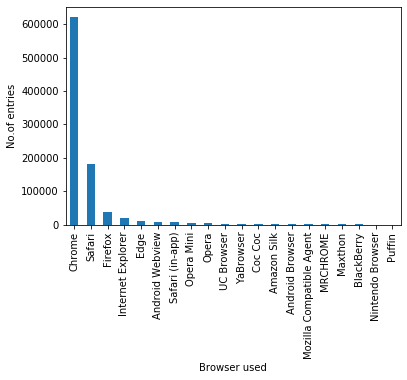

In [48]:
train['device.browser'].value_counts()[:20].plot.bar()  #plotting top 20 used browsers
plt.ylabel("No.of entries")
plt.xlabel("Browser used")

Text(0.5, 0, 'OS used')

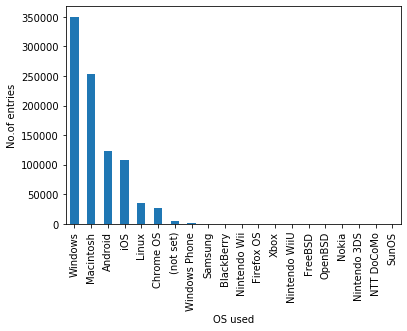

In [49]:
train['device.operatingSystem'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("OS used")

Text(0.5, 0, 'isMobile?')

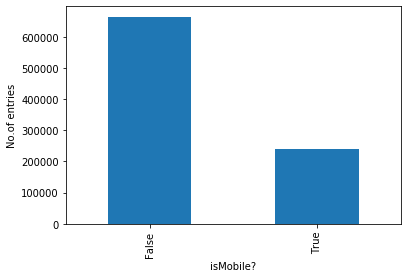

In [50]:
train['device.isMobile'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("isMobile?")

Text(0.5, 0, 'Device Category')

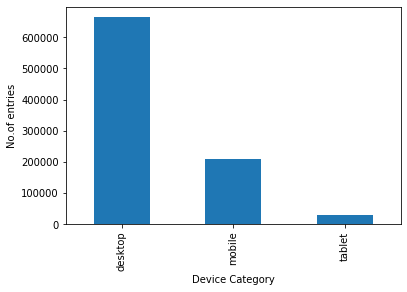

In [51]:
train['device.deviceCategory'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("Device Category")

<h3>Looking over 'geoNetwork' sub-features</h3>      

Text(0.5, 0, 'Continent')

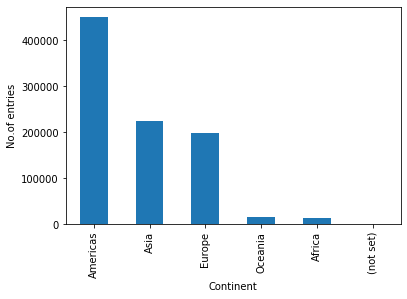

In [52]:
train['geoNetwork.continent'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("Continent")

Text(0.5, 0, 'Sub-Continent')

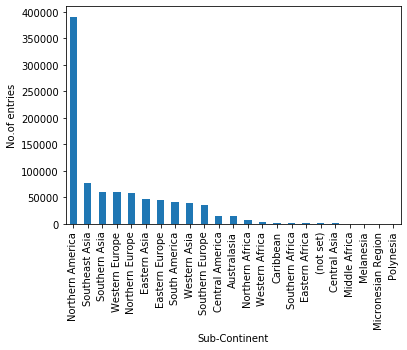

In [53]:
train['geoNetwork.subContinent'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("Sub-Continent")

Text(0.5, 0, 'Country')

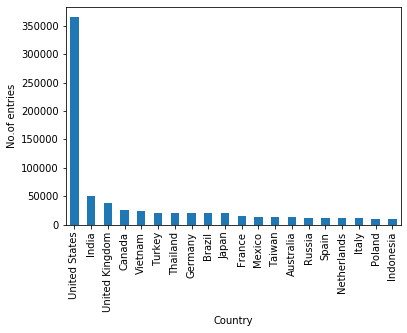

In [54]:
train['geoNetwork.country'].value_counts()[:20].plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("Country")

Text(0.5, 0, 'Region')

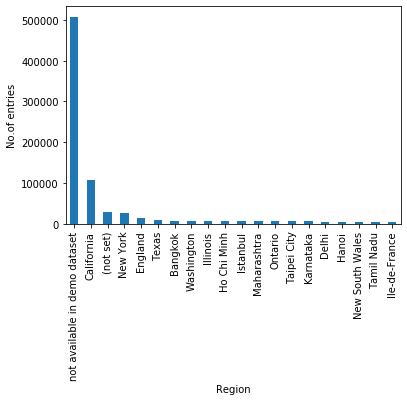

In [55]:
train['geoNetwork.region'].value_counts()[:20].plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("Region")

Text(0.5, 0, 'Metro')

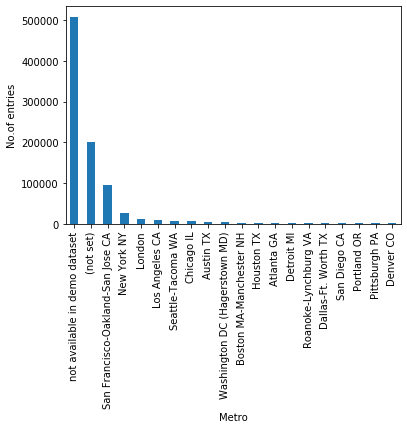

In [56]:
train['geoNetwork.metro'].value_counts()[:20].plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("Metro")

Text(0.5, 0, 'City')

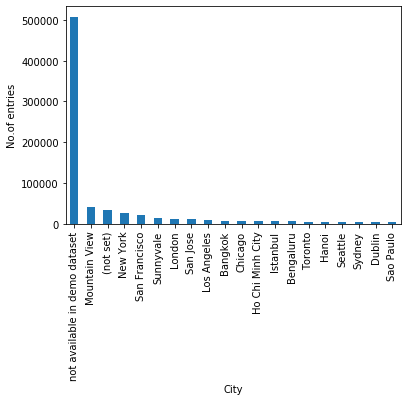

In [57]:
train['geoNetwork.city'].value_counts()[:20].plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("City")

Text(0.5, 0, 'Network Domain')

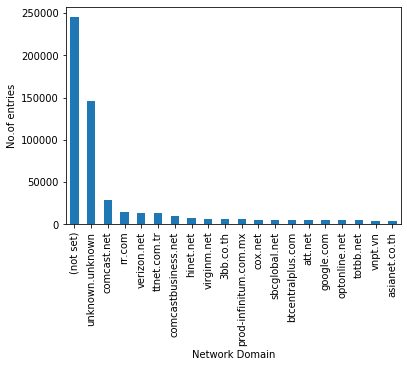

In [58]:
train['geoNetwork.networkDomain'].value_counts()[:20].plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("Network Domain")

<b> Observation-</b> A major portion of rows in geoNetwork.region, geoNetwork.metro, geoNetwork.city has 'not available in demo data' as value

<h3>Looking over 'total' sub-features</h3>

In [59]:
train['totals.hits'].value_counts()

1      446754
2      137952
3       70402
4       42444
5       30939
        ...  
178         1
239         1
483         1
183         1
357         1
Name: totals.hits, Length: 274, dtype: int64

In [60]:
train['totals.pageviews'].value_counts()

1      452522
2      143770
3       73835
4       45192
5       33411
        ...  
300         1
164         1
275         1
154         1
162         1
Name: totals.pageviews, Length: 213, dtype: int64

In [61]:
train['totals.transactionRevenue'].value_counts()

16990000     256
18990000     189
33590000     187
44790000     170
13590000     135
            ... 
56730000       1
158560000      1
523390000      1
73740000       1
16930000       1
Name: totals.transactionRevenue, Length: 5332, dtype: int64

Adding these new features to the dataset-

1. mean
2. median
3. min
4. max
5. sum
   of 
    1. total.hits
    2. total.pageviews, 
   per unique visitor per day

In [358]:
#Originally the values were of string type and had to be converted to type float for further grouping
train['totals.hits']= [float(x) for x in train['totals.hits']]
train['totals.pageviews']= [float(x) for x in train['totals.pageviews']]

test['totals.hits']= [float(x) for x in test['totals.hits']]
test['totals.pageviews']= [float(x) for x in test['totals.pageviews']]

In [359]:
print(train.shape)
print(test.shape)

(903653, 46)
(804684, 35)


In [351]:
per_visitor_train = train.groupby(['fullVisitorId']).agg('sum')

In [352]:
per_visitor_train['fullVisitorId'] = per_visitor_train.index #adding fullVisitorId so that we can map this dataset to our train dataset

In [354]:
per_visitor_train['mean_hits_per_day'] = per_visitor_train.groupby(['Date'])['totals.hits'].transform('mean')
per_visitor_train['median_hits_per_day'] = per_visitor_train.groupby(['Date'])['totals.hits'].transform('median')
per_visitor_train['sum_hits_per_day'] = per_visitor_train.groupby(['Date'])['totals.hits'].transform('sum')
per_visitor_train['min_hits_per_day'] = per_visitor_train.groupby(['Date'])['totals.hits'].transform('min')
per_visitor_train['max_hits_per_day'] = per_visitor_train.groupby(['Date'])['totals.hits'].transform('max')

per_visitor_train['mean_pageviews_per_day'] = per_visitor_train.groupby(['Date'])['totals.pageviews'].transform('mean')
per_visitor_train['median_pageviews_per_day'] = per_visitor_train.groupby(['Date'])['totals.pageviews'].transform('median')
per_visitor_train['sum_pageviews_per_day'] = per_visitor_train.groupby(['Date'])['totals.pageviews'].transform('sum')
per_visitor_train['min_pageviews_per_day'] = per_visitor_train.groupby(['Date'])['totals.pageviews'].transform('min')
per_visitor_train['max_pageviews_per_day'] = per_visitor_train.groupby(['Date'])['totals.pageviews'].transform('max')

In [355]:
per_visitor_train = per_visitor_train[['fullVisitorId', 'mean_hits_per_day','median_hits_per_day','sum_hits_per_day','min_hits_per_day','max_hits_per_day','mean_pageviews_per_day','median_pageviews_per_day','sum_pageviews_per_day','min_pageviews_per_day','max_pageviews_per_day']]
#per_visitor_train.head(1)

train = train.join(per_visitor_train, on='fullVisitorId', how='inner', rsuffix='_') #mapping on fullVisitorId
train.drop(['fullVisitorId_'], axis=1, inplace=True)

In [356]:
train.head(2)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,mean_hits_per_day,median_hits_per_day,sum_hits_per_day,min_hits_per_day,max_hits_per_day,mean_pageviews_per_day,median_pageviews_per_day,sum_pageviews_per_day,min_pageviews_per_day,max_pageviews_per_day
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,...,3.943076,1.0,83747.0,1.0,233.0,3.371298,1.0,71603.0,1.0,176.0
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,...,3.943076,1.0,83747.0,1.0,233.0,3.371298,1.0,71603.0,1.0,176.0


In [360]:
per_visitor_test = test.groupby(['fullVisitorId']).agg('sum')
per_visitor_test['fullVisitorId'] = per_visitor_test.index

per_visitor_test['mean_hits_per_day'] = per_visitor_test.groupby(['Date'])['totals.hits'].transform('mean')
per_visitor_test['median_hits_per_day'] = per_visitor_test.groupby(['Date'])['totals.hits'].transform('median')
per_visitor_test['sum_hits_per_day'] = per_visitor_test.groupby(['Date'])['totals.hits'].transform('sum')
per_visitor_test['min_hits_per_day'] = per_visitor_test.groupby(['Date'])['totals.hits'].transform('min')
per_visitor_test['max_hits_per_day'] = per_visitor_test.groupby(['Date'])['totals.hits'].transform('max')

per_visitor_test['mean_pageviews_per_day'] = per_visitor_test.groupby(['Date'])['totals.pageviews'].transform('mean')
per_visitor_test['median_pageviews_per_day'] = per_visitor_test.groupby(['Date'])['totals.pageviews'].transform('median')
per_visitor_test['sum_pageviews_per_day'] = per_visitor_test.groupby(['Date'])['totals.pageviews'].transform('sum')
per_visitor_test['min_pageviews_per_day'] = per_visitor_test.groupby(['Date'])['totals.pageviews'].transform('min')
per_visitor_test['max_pageviews_per_day'] = per_visitor_test.groupby(['Date'])['totals.pageviews'].transform('max')

per_visitor_test = per_visitor_test[['fullVisitorId', 'mean_hits_per_day','median_hits_per_day','sum_hits_per_day','min_hits_per_day','max_hits_per_day','mean_pageviews_per_day','median_pageviews_per_day','sum_pageviews_per_day','min_pageviews_per_day','max_pageviews_per_day']]
#per_visitor_train.head(1)

test = test.join(per_visitor_test, on='fullVisitorId', how='inner', rsuffix='_') #mapping on fullVisitorId
test.drop(['fullVisitorId_'], axis=1, inplace=True)

In [361]:
print(train.shape)
print(test.shape)

(903653, 46)
(804684, 45)


<h3>Looking over 'trafficSource' sub-features</h3>

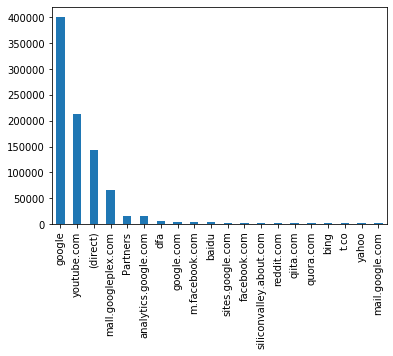

In [62]:
train['trafficSource.source'].value_counts()[:20].plot.bar()

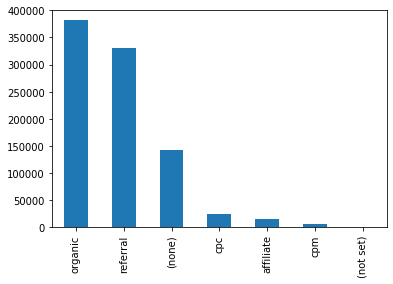

In [63]:
train['trafficSource.medium'].value_counts().plot.bar()

In [64]:
train['trafficSource.keyword'].value_counts()

(not provided)                                     366363
6qEhsCssdK0z36ri                                    11503
(Remarketing/Content targeting)                      2298
1hZbAqLCbjwfgOH7                                     2264
google merchandise store                             2209
                                                    ...  
youtuber printed t shirt online buy                     1
Google logo t-shirt                                     1
gadget online store                                     1
google view malaysia                                    1
boneka yang berfungsi untuk menghalyskan tshirt         1
Name: trafficSource.keyword, Length: 3659, dtype: int64

In [65]:
train['trafficSource.adwordsClickInfo.page'].value_counts() 

1     21362
2        73
3        10
5         7
7         3
9         2
4         2
14        1
Name: trafficSource.adwordsClickInfo.page, dtype: int64

In [66]:
train['trafficSource.adwordsClickInfo.slot'].value_counts() 

Top    20956
RHS      504
Name: trafficSource.adwordsClickInfo.slot, dtype: int64

In [67]:
train['trafficSource.adwordsClickInfo.gclId'].value_counts() 

Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3ZdwYO8GTsjiBFd5MPHStZa9y_9NCrI8X97oaAglc8P8HAQ      70
Cj0KEQjw1ee_BRD3hK6x993YzeoBEiQA5RH_BEA562M9tvl_mtnAFvtDnDqOQRp1RvxMMgwjcX1LAfwaAj4o8P8HAQ      41
CJH1vbf94M8CFUElgQodyakHgQ                                                                      29
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4LcssmB_RWgvpPnltzlzj5rGwqx5lk87wC5CjfcqzneNZewaAiAp8P8HAQ      27
CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBEJui6ggr6ocA-eDC2-lX7W1m5IA1c_qNbzwZVTqUanxoCb5rw_wcB        24
                                                                                                ..
Cj0KEQjwpZO_BRDym6K_nMye7cEBEiQAVA7RaFY32mLAlcFQ189RWUEB-pItqkbm-JLmcIY9sVlEd08aAj_R8P8HAQ       1
CJ6H48LEvNECFUtYDQod2oMAsA                                                                       1
CjwKEAiAmdXBBRD0hZCVkYHTl20SJACWsZj9MZb4EJXThlnR08yRTpcqu0qB0IDlbLVWV7paMikC-xoCEiHw_wcB         1
CJShxsHKv9ECFdc7gQodn-sKBA                                                                       1
Cj0KCQjwja

In [68]:
train['trafficSource.adwordsClickInfo.adNetworkType'].value_counts() 

Google Search      21453
Search partners        7
Name: trafficSource.adwordsClickInfo.adNetworkType, dtype: int64

In [69]:
train['trafficSource.campaign'].value_counts() 

(not set)                                          865347
Data Share Promo                                    16403
AW - Dynamic Search Ads Whole Site                  14244
AW - Accessories                                     7070
test-liyuhz                                           392
AW - Electronics                                       96
Retail (DO NOT EDIT owners nophakun and tianyu)        50
AW - Apparel                                           46
All Products                                            4
Data Share                                              1
Name: trafficSource.campaign, dtype: int64

In [70]:
train['trafficSource.adContent'].value_counts()

Google Merchandise Collection                  5122
Google Online Store                            1245
Display Ad created 3/11/14                      967
Full auto ad IMAGE ONLY                         822
Ad from 12/13/16                                610
Ad from 11/3/16                                 489
Display Ad created 3/11/15                      392
{KeyWord:Google Brand Items}                    251
{KeyWord:Google Merchandise}                    155
Ad from 11/7/16                                 123
First Full Auto Template Test Ad                 87
Google Merchandise                               87
20% discount                                     75
{KeyWord:Google Branded Gear}                    67
{KeyWord:Looking for Google Bags?}               65
Swag with Google Logos                           64
Display Ad created 11/17/14                      50
{KeyWord:Want Google Stickers?}                  42
JD_5a_v1                                         41
{KeyWord:Goo

<h3>Checking for Missing values

In [71]:
def missing_data(data):
    '''These function will find the no. of rows that have missing data and will also return
        the percentage of total missing value'''
    
    #isnull()-gives rows that does not contain values
    total = data.isnull().sum().sort_values(ascending = False) # in descending order
    
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    
    return pd.concat([total, percent], axis=1, keys=['Total rows missing', 'Percentage'])

In [72]:
print("Missing data:\n")
missing_data(train)

Missing data:



,Total rows missing,Percentage
trafficSource.adContent,892707,98.788694
totals.transactionRevenue,892138,98.725728
trafficSource.adwordsClickInfo.adNetworkType,882193,97.625195
trafficSource.adwordsClickInfo.slot,882193,97.625195
trafficSource.adwordsClickInfo.page,882193,97.625195
trafficSource.adwordsClickInfo.gclId,882092,97.614018
trafficSource.referralPath,572712,63.377425
trafficSource.keyword,502929,55.655102
totals.pageviews,100,0.011066
visitStartTime,0,0.000000


Observation: 
1. Most of the sub-columns of trafficSource show very high missing values
2. 98.725728% rows of transactionRevenue has missing value

<h3>Let's check how many rows of transactionRevenue actually generate revenue

In [362]:
train['totals.transactionRevenue'].fillna(0, inplace=True) #filling the NaN with 0-- to proceed 

In [363]:
# the values are in string format so it's important to convert them to int values
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].apply(lambda x:int(x))


In [75]:
#findind all rows that generate revenue
no_of_revenue_generating_rows = train[train['totals.transactionRevenue']>0].shape
no_of_revenue_generating_rows

(11515, 36)

In [76]:
percent_of_revenue_generating_rows = no_of_revenue_generating_rows[0]/train.shape[0]*100
percent_of_revenue_generating_rows

1.27427231470487

There are only 1.27% of the rows(i.e. 11515 rows) in the entire train dataset that is contributing to the revenue 

In [77]:
train['totals.transactionRevenue'].sum()

1540071240000

In [78]:
#findind all rows that generate revenue
a = train[train['totals.transactionRevenue']>10].shape
a

(11515, 36)

<h3>Who are contributing to the revenue?

In [79]:
#finding total revenue generated by each user
per_user_revenue = train.groupby('fullVisitorId').agg({'totals.transactionRevenue':'sum'})

In [80]:
per_user_revenue.head()

,totals.transactionRevenue
fullVisitorId,
0000010278554503158,0
0000020424342248747,0
0000027376579751715,0
0000039460501403861,0
0000040862739425590,0


In [81]:
revenue_generating_users = per_user_revenue[per_user_revenue['totals.transactionRevenue']>0]
revenue_generating_users.head()

,totals.transactionRevenue
fullVisitorId,
0000213131142648941,33590000
0002871498069867123,96350000
0003450834640354121,57950000
0003961110741104601,4980000
000435324061339869,44790000


Text(0.5, 1.0, 'Probabilistic Distribution plot showing distribution of total revenue generated')

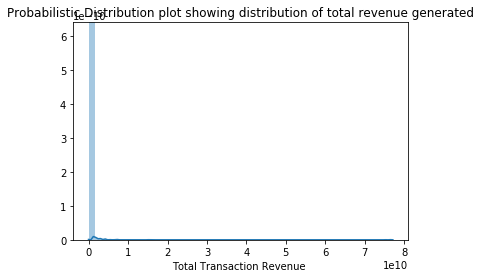

In [82]:
sns.distplot(revenue_generating_users['totals.transactionRevenue'])

plt.xlabel("Total Transaction Revenue ")
plt.title("Probabilistic Distribution plot showing distribution of total revenue generated")

Okay! So as per my assumption earlier, it proves here that only a small percentage of people actually contribute to the revenue. 

Text(0.5, 1.0, 'Revenue Graph')

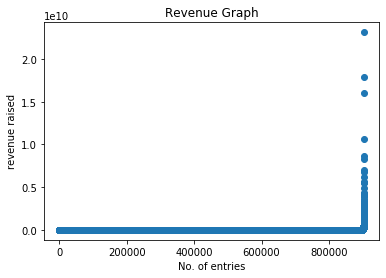

In [83]:
plt.scatter(range(train.shape[0]), np.sort(train['totals.transactionRevenue'].values))
plt.xlabel("No. of entries")
plt.ylabel("revenue raised")
plt.title("Revenue Graph")

The graph clearly indicated that only a very small proportion of users actually contribute to the revenue.
Rest are just mere entries.

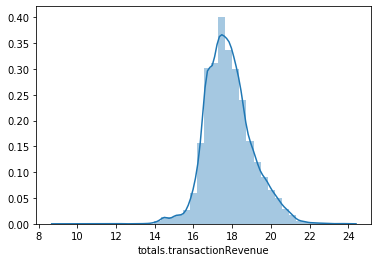

In [84]:
#Plotting a log distribution plot on entries where transactionRevenue>0
ax = sns.distplot(np.log(train[train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"] + 0.01), bins=40, kde=True)


<h3>Checking no.of visits per day

In [85]:
#value_counts()- will give total no.of entries for that day which is equivalent to no. of visits
#.sort_values('index') - will give me the frame in order of date

no_visits_per_day = train['date'].value_counts().to_frame().reset_index().sort_values('index')
no_visits_per_day = no_visits_per_day.rename(columns = {"index" : "date", "date" : "visits"})

In [86]:
no_visits_per_day

,date,visits
312,2016-08-01,1711
251,2016-08-02,2140
75,2016-08-03,2890
49,2016-08-04,3161
106,2016-08-05,2702
...,...,...
172,2017-07-28,2433
335,2017-07-29,1597
293,2017-07-30,1799
124,2017-07-31,2620


Text(0.5, 1.0, 'no.of visits/entries per day')

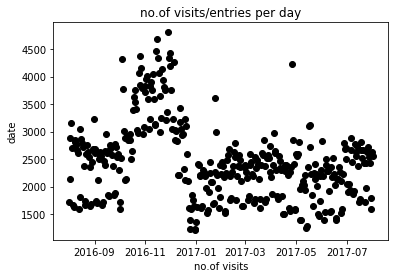

In [87]:
plt.plot(no_visits_per_day['date'], no_visits_per_day['visits'], 'o', color='black')
plt.xlabel("date")
plt.ylabel("no.of visits")
plt.title("no.of visits/entries per day")

Here it can be seen that in the duration of Nov 2016 to Dec 2016 the no.of entries is more comparitive to other months. Let's check the revenue in all these months and then we can clearly state whether time will be an importtant factor or not.

In [88]:
#revenue per date
per_date_revenue = train.groupby('date').agg({'totals.transactionRevenue':'sum'})
per_date_revenue.head(2)

,totals.transactionRevenue
date,
2016-08-01,6116060000
2016-08-02,1361190000


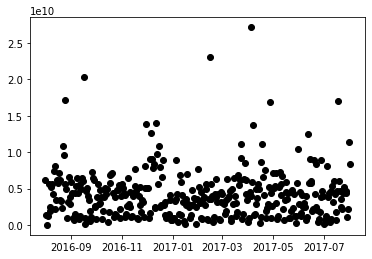

In [89]:
plt.plot(per_date_revenue, 'o', color='black')
plt.ylabel("Revenue generated")
plt.xlabel("Date")
plt.title("Revenue generated per day")

Though the no. of entries were more in Oct-Nov 2016, the revenue generation does not show any differences.

<h3>Per month

Text(0.5, 1.0, 'Revenue generated per month')

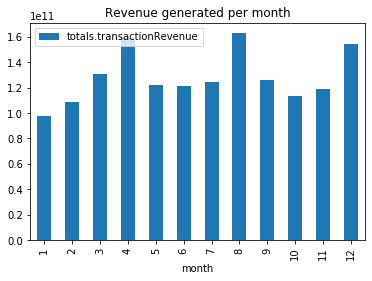

In [90]:
#finding revenue generated per month
revnue_generated_per_month = train.groupby("month").agg({'totals.transactionRevenue':'sum'})

revnue_generated_per_month.plot.bar()
plt.title("Revenue generated per month")

Text(0.5, 1.0, 'No.of sessions per month')

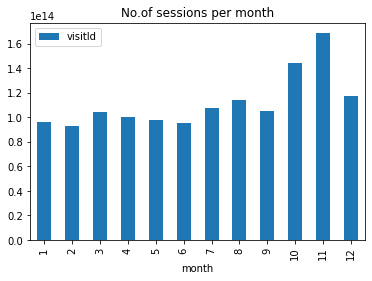

In [91]:
#No.of sessions per month
sessions_per_month = train.groupby("month").agg({'visitId':'sum'})
sessions_per_month.plot.bar()
plt.title("No.of sessions per month")

By looking at the above 2 plots it can be concluded that April and August has high revenue/session ratio while Nov has the lowest revenue/session ratio.


<h3>Per weekday

Text(0.5, 1.0, 'Revenue generated per weekday')

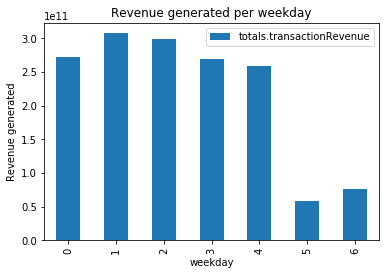

In [92]:
#0-Monday
#6-Sunday

revnue_generated_per_weekday = train.groupby("weekday").agg({'totals.transactionRevenue':'sum'})

revnue_generated_per_weekday.plot.bar()
plt.ylabel("Revenue generated")
plt.xlabel("weekday")
plt.title("Revenue generated per weekday")

Text(0.5, 1.0, 'No.of entries per weekday')

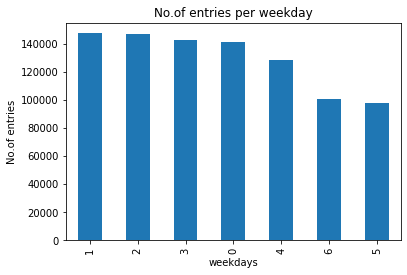

In [93]:
train['weekday'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("weekdays")
plt.title("No.of entries per weekday")

1. Surprisingly, the number of entries/sessions are more in the weekdays than in the weekend.
2. Highest revenue is generated on Tuesday

<h3>Per channel

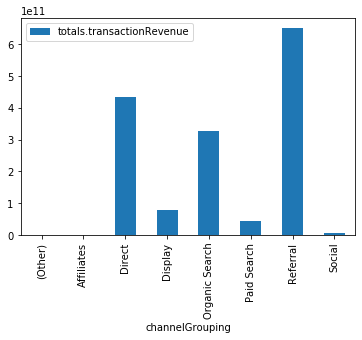

In [94]:
revnue_generated_by_channel = train.groupby("channelGrouping").agg({'totals.transactionRevenue':'sum'})

revnue_generated_by_channel.plot.bar()
plt.ylabel("Revenue generated")
plt.xlabel("channel")
plt.title("Revenue generated per channel")

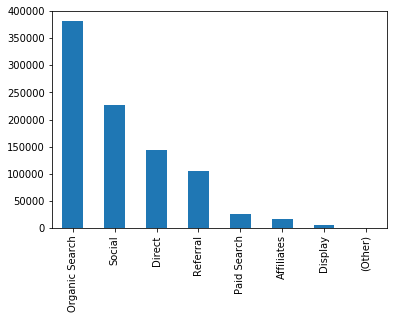

In [95]:
#we've seen this earlier
train['channelGrouping'].value_counts().plot.bar()
plt.ylabel("No. of entries")
plt.xlabel("channel")
plt.title("No. of entries per channel")

Referals generate most revenue though the no.of entries is comparitively much lower than organic search, social and direct

<h3>Per Operarting System

Text(0.5, 1.0, 'Revenue generated per OS')

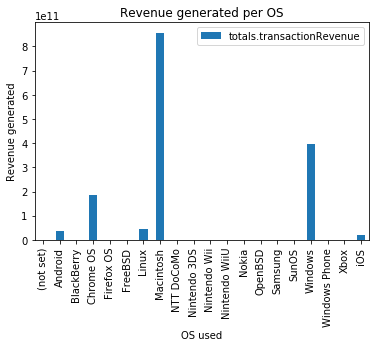

In [96]:
revnue_generated_by_os = train.groupby("device.operatingSystem").agg({'totals.transactionRevenue':'sum'})

revnue_generated_by_os.plot.bar()
plt.ylabel("Revenue generated")
plt.xlabel("OS used")
plt.title("Revenue generated per OS")

Text(0.5, 1.0, 'No.of entries per OS')

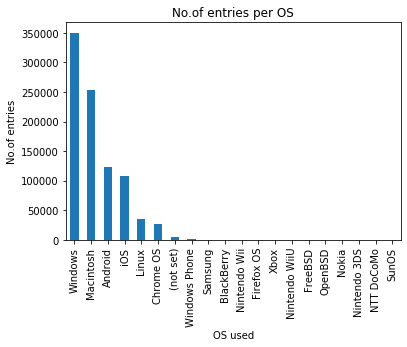

In [97]:
train['device.operatingSystem'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("OS used")
plt.title("No.of entries per OS")

1. Here it can be seen that most of the entries were from Windows OS but maximum revenue is generated by users using Machintosh
2. It seems like only Machintosh, Windows, Chrome OS, Android and IOS using users contribute to revenue
3. Android and IOS users have high no.of entries but have contributes very less to the revenue

<h3>Per device category

Text(0.5, 1.0, 'Revenue generated per device')

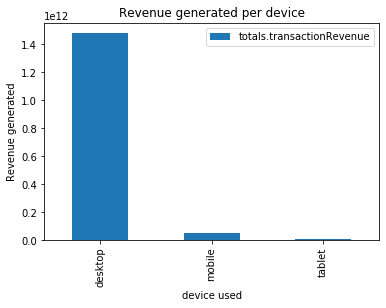

In [98]:
revnue_generated_by_device_category = train.groupby("device.deviceCategory").agg({'totals.transactionRevenue':'sum'})

revnue_generated_by_device_category.plot.bar()
plt.ylabel("Revenue generated")
plt.xlabel("device used")
plt.title("Revenue generated per device")

Text(0.5, 1.0, 'No.of entries per device')

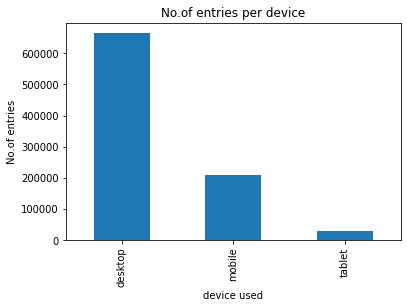

In [99]:
train['device.deviceCategory'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("device used")
plt.title("No.of entries per device")

1. Most revenue is generated by users using desktop. 
2. People using mobile low revenue/entries ratio

<h3>Per continent

In [100]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adContent', 'year', 'month', 'Date', 'weekday', 'hour'],
      dtype='object')

Text(0.5, 1.0, 'Revenue generated per continent')

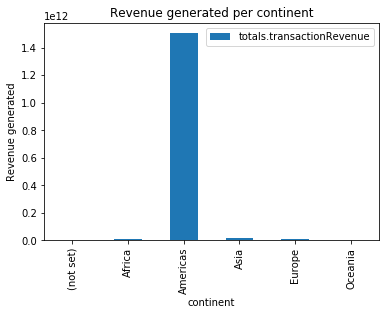

In [101]:
revnue_generated_by_continent = train.groupby("geoNetwork.continent").agg({'totals.transactionRevenue':'sum'})

revnue_generated_by_continent.plot.bar()
plt.ylabel("Revenue generated")
plt.xlabel("continent")
plt.title("Revenue generated per continent")

Text(0.5, 1.0, 'No.of entries per continent')

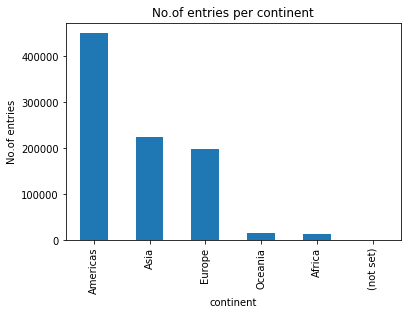

In [102]:
train['geoNetwork.continent'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("continent")
plt.title("No.of entries per continent")

In [103]:
revenue_generated_by_america =train[train['geoNetwork.continent']=='Americas']['totals.transactionRevenue'].sum()
total_revenue = train['totals.transactionRevenue'].sum()
print("percentage contribution by america:", revenue_generated_by_america/total_revenue*100)

percentage contribution by america: 97.70142840924684


The americans contribute to more than 97% to the revenue alone.

<h3> Pe sub-Continent

Text(0.5, 1.0, 'Revenue generated per subcontinent')

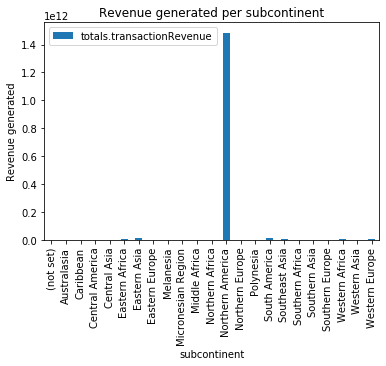

In [104]:
revnue_generated_by_subcontinent = train.groupby("geoNetwork.subContinent").agg({'totals.transactionRevenue':'sum'})

revnue_generated_by_subcontinent.plot.bar()
plt.ylabel("Revenue generated")
plt.xlabel("subcontinent")
plt.title("Revenue generated per subcontinent")

Text(0.5, 0, 'Sub-Continent')

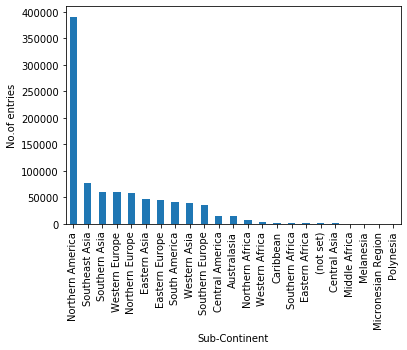

In [105]:
train['geoNetwork.subContinent'].value_counts().plot.bar()
plt.ylabel("No.of entries")
plt.xlabel("Sub-Continent")

1. Northern America contribute maximum to the revenue.
2. Asian and European contries have significant no.of sessions but doesnot contribute to the revenue much.

<H3> Checking how many customers has visited only once and how many users are regular

In [106]:
no_of_users_visited_once = train[train['visitNumber']==1]
print("No. of customers who visited only once", no_of_users_visited_once.shape[0])
print("Percentage of people who visited only once ", no_of_users_visited_once.shape[0]/ train.shape[0]*100)
print("total revenue generated by people who visited only once:",no_of_users_visited_once['totals.transactionRevenue'].sum())
print("Revenue generated per person by such users:",((no_of_users_visited_once['totals.transactionRevenue'].sum())/(no_of_users_visited_once.shape[0])))


No. of customers who visited only once 703060
Percentage of people who visited only once  77.801988152532
total revenue generated by people who visited only once: 382325960000
Revenue generated per person by such users: 543802.7479873695


In [107]:
no_of_users_visited_more_than_once = train[train['visitNumber']>1] 
print("No. of customers who visited more than once", no_of_users_visited_more_than_once.shape[0])
print("Percentage of people who visited more than once ", no_of_users_visited_more_than_once.shape[0]/ train.shape[0]*100)
print("total revenue generated by people who visited more than once:",no_of_users_visited_more_than_once['totals.transactionRevenue'].sum())
print("Revenue generated per person by such users:",((no_of_users_visited_more_than_once['totals.transactionRevenue'].sum())/(no_of_users_visited_more_than_once.shape[0])))


No. of customers who visited more than once 200593
Percentage of people who visited more than once  22.198011847468
total revenue generated by people who visited more than once: 1157745280000
Revenue generated per person by such users: 5771613.565777469


In [108]:
regular_visitors = train[train['visitNumber']>10]
print("No. of customers who visited more than once", regular_visitors.shape[0])
print("Percentage of people who visited more than once ", regular_visitors.shape[0]/ train.shape[0]*100)
print("total revenue generated by people who visited more than once:",regular_visitors['totals.transactionRevenue'].sum())
print("Revenue generated per person by such users:",((regular_visitors['totals.transactionRevenue'].sum())/(regular_visitors.shape[0])))



No. of customers who visited more than once 18810
Percentage of people who visited more than once  2.08155121490218
total revenue generated by people who visited more than once: 248664270000
Revenue generated per person by such users: 13219791.068580542


Conclusion: 
1. 77.8% of total users purchased from the store only once while 22.2% were regular visitors
2. Avg Revenue generated per customer who came back to the store again is 10+ times more than the users who never came back.
3. And the regular users (assuming regular customers are those who purchased the products more than 10 times) are the customers who contribute maximum to the revenue

<b>By now, i've studied all the features in my dataset and I'm ready to proceed.

In [364]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adContent', 'year', 'month', 'Date', 'weekday', 'hour',
       'mean_hits_per_day', 'median_hits_per_day', 'sum_hits_per_day',
       'min_hits_per_day', 'max_hits_per_day', 'mean_pagev

In [365]:
test.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.referralPath', 'trafficSource.adContent', 'year',
       'month', 'Date', 'weekday', 'hour', 'mean_hits_per_day',
       'median_hits_per_day', 'sum_hits_per_day', 'min_hits_per_day',
       'max_hits_per_day', 'mean_pageviews_per_day',
       

In [366]:
#sessionId will be unique for every row and will not provide any meaningful data to our model. 
#So it can be easily dropped
train = train.drop(['sessionId'], axis=1)
test = test.drop('sessionId', axis=1)

In [367]:
print(train.shape)
print(test.shape)

(903653, 45)
(804684, 44)


Before vectorizing my categorical and numerical features I'll split my train dataset in 80-20 ratio into train and validation data.
* Splitting it before vectorizing to avoid Data Leakage

<h3> Splitting train data 80:20

In [369]:
import datetime

In [370]:
#splitting on basis of date

x_train = train[train['date']<=datetime.date(2017,5,31)] #1st Aug 2016 to 31st May,2017
x_val = train[train['date']>datetime.date(2017,5,31)]#1st June to 1st Aug 2017
print(x_train.shape)
print(x_val.shape)

(765707, 45)
(137946, 45)


In [371]:
#saving the transactionRevenue in y (as it needs to be predicted)
y_train = x_train['totals.transactionRevenue'].to_frame()
y_val = x_val['totals.transactionRevenue'].to_frame()

In [372]:
#I have to predict log of total revenue per user
#So I need to convert y to log form before splitting.

y_train= np.log1p(y_train['totals.transactionRevenue'].astype(float))
y_val= np.log1p(y_val['totals.transactionRevenue'].astype(float))

In [161]:
#y = train['totals.transactionRevenue'] 

#dropping totals.transactionRevenue from train dataset
#train = train.drop(["totals.transactionRevenue"],axis=1)

In [373]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(test.shape)

#note--
########abhi bhi x_train and x_val mei transactionRevenue hai

(765707, 45)
(765707,)
(137946, 45)
(137946,)
(804684, 44)


<h3> Vectorizing Categorical data

In [374]:
from sklearn.preprocessing import LabelEncoder

In [382]:
categorical_columns = ['channelGrouping','device.browser','device.operatingSystem', 'device.isMobile', 
                       'device.deviceCategory','geoNetwork.continent', 'geoNetwork.subContinent', 
                       'geoNetwork.country','geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
                       'geoNetwork.networkDomain',
                       'trafficSource.campaign','trafficSource.source', 'trafficSource.medium', 
                       'trafficSource.keyword','trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page',
                       'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.gclId',
                       'trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adContent']

Borrowing this class LabelEncoderExt from https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values to handle situations where validation and test data encounter values that are not already seen in train dataset.

In [379]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [380]:
x_train.head(2)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,mean_hits_per_day,median_hits_per_day,sum_hits_per_day,min_hits_per_day,max_hits_per_day,mean_pageviews_per_day,median_pageviews_per_day,sum_pageviews_per_day,min_pageviews_per_day,max_pageviews_per_day
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1,1472830385,Chrome,Windows,False,desktop,...,3.943076,1.0,83747.0,1.0,233.0,3.371298,1.0,71603.0,1.0,176.0
1,Organic Search,2016-09-02,377306020877927890,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,...,3.943076,1.0,83747.0,1.0,233.0,3.371298,1.0,71603.0,1.0,176.0


In [383]:
#.values()- gives the values in that column in array format (without index)

start = pd.datetime.now().minute

for c in categorical_columns:

    le = LabelEncoderExt()
    
    train_vals = list(x_train[c].values.astype(str)) 
    cv_vals = list(x_val[c].values.astype(str))
    test_vals = list(test[c].values.astype(str))
    
    #LabelEncoder() will now be fit on the train column values
    
    le.fit(train_vals)
    
    x_train[c] = le.transform(train_vals)
    x_val[c] = le.transform(cv_vals)
    test[c] = le.transform(test_vals)
    
    
print("Time taken:", pd.datetime.now().minute- start, "mins")

Time taken: -8 mins


In [384]:
x_train.head(2)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,mean_hits_per_day,median_hits_per_day,sum_hits_per_day,min_hits_per_day,max_hits_per_day,mean_pageviews_per_day,median_pageviews_per_day,sum_pageviews_per_day,min_pageviews_per_day,max_pageviews_per_day
0,4,2016-09-02,1131660440785968503,1472830385,1,1472830385,49,17,0,1,...,3.943076,1.0,83747.0,1.0,233.0,3.371298,1.0,71603.0,1.0,176.0
1,4,2016-09-02,377306020877927890,1472880147,1,1472880147,6,7,0,1,...,3.943076,1.0,83747.0,1.0,233.0,3.371298,1.0,71603.0,1.0,176.0


<h2> Vectorizing Numerical Data

In [385]:
from sklearn.preprocessing import Normalizer

In [409]:
numerical_columns = ['year','month', 'Date', 'weekday', 'hour',
        'mean_hits_per_day','median_hits_per_day', 'sum_hits_per_day', 'min_hits_per_day','max_hits_per_day',
       'mean_pageviews_per_day','median_pageviews_per_day', 'sum_pageviews_per_day','min_pageviews_per_day',
        'max_pageviews_per_day','totals.hits']#, 'totals.pageviews']

#fitting the Normalizer() on train data and transforming complete data (to aovid Data Leakage)

for c in numerical_columns:

    n_vect = Normalizer()
    
    n_vect.fit(x_train[c].values.reshape(1,-1))
    
    #########
    a = n_vect.transform(x_train[c].values.reshape(1,-1)).reshape(-1,1)
    list1=[]
    for ele in a:
        list1.append(float(ele))
        
    x_train[c] = list1
    
    #############
    b = n_vect.transform(x_val[c].values.reshape(1,-1)).reshape(-1,1)
    list2=[]
    for ele in b:
        list2.append(float(ele))
        
    x_val[c] = list2
    
    ###############
    d = n_vect.transform(test[c].values.reshape(1,-1)).reshape(-1,1)
    list3=[]
    for ele in d:
        list3.append(float(ele))
        
    test[c] = list3
    

In [410]:
#train['totals.pageviews'].fillna(0).unique()

<h3>Building Models

In [411]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(test.shape)

(765707, 45)
(765707,)
(137946, 45)
(137946,)
(804684, 44)


In [412]:
x_train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adContent', 'year', 'month', 'Date', 'weekday', 'hour',
       'mean_hits_per_day', 'median_hits_per_day', 'sum_hits_per_day',
       'min_hits_per_day', 'max_hits_per_day', 'mean_pageviews_per_day'

In [413]:
#storing the fullVisitorId
fullVisitorId_train = x_train['fullVisitorId']
fullVisitorId_val = x_val['fullVisitorId']
fullVisitorId_test = test['fullVisitorId']

In [415]:
#fullVisitorId_train[0]#---in str format

'1131660440785968503'

In [416]:
#dropping columns that wont contribute to the model
#also dropping transactionRevenue from train and val data

new_x_train = x_train.drop(['date','fullVisitorId','visitId','visitStartTime','visitNumber','totals.transactionRevenue'],axis=1)
new_x_val = x_val.drop(['date','fullVisitorId','visitId','visitStartTime','visitNumber','totals.transactionRevenue'],axis=1)
new_test = test.drop(['date','fullVisitorId','visitId','visitStartTime','visitNumber'],axis=1)

In [531]:
print(new_x_train.shape)
print(y_train.shape)
print(new_x_val.shape)
print(y_val.shape)
print(new_test.shape)

(765707, 39)
(765707,)
(137946, 39)
(137946,)
(804684, 39)


<h3>Modelling

<b>Metric- </b>Root mean square error (rmse)

In [502]:
new_x_train.columns

Index(['channelGrouping', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adContent', 'year', 'month', 'Date', 'weekday', 'hour',
       'mean_hits_per_day', 'median_hits_per_day', 'sum_hits_per_day',
       'min_hits_per_day', 'max_hits_per_day', 'mean_pageviews_per_day',
       'median_pageviews_per_day', 'sum_pageviews_per_day',
       'min_pageviews_per_day', 'max_pageviews_per

In [535]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [ ]:
depth = [4]
min_sample_split = [2]
parameters = {'max_depth':depth , 'min_samples_split': min_sample_split } 
neigh = tree.DecisionTreeClassifier()
model = GridSearchCV(neigh, parameters,scoring='roc_auc') 
model.fit(new_x_train,y_train)

In [542]:
from sklearn import preprocessing
from sklearn import utils
lab_enc = preprocessing.LabelEncoder()

training_scores_Y  = np.array( [1.4, 9.2, 2.5, 2.2] )

In [543]:
training_scores_encoded = lab_enc.fit_transform(training_scores_Y)
print(training_scores_encoded)
print(utils.multiclass.type_of_target(training_scores_Y))
print(utils.multiclass.type_of_target(training_scores_Y.astype('int')))
print(utils.multiclass.type_of_target(training_scores_encoded))

[0 3 2 1]
continuous
multiclass
multiclass


In [545]:
xgb_model = xgb.XGBClassifier(learning_rate=0.02, n_estimators=5,max_depth= 2, objective= 'binary:logistic',
silent=True, nthread=1)

In [ ]:
#hyperparameter tuning
estimator = [5, 10, 50, 100, 200]
depth = [2, 3, 4, 5, 6, 7, 8]

final_train_auc = [] 
final_cv_auc = []

for i in tqdm(estimator): 
    train_auc = []
    cv_auc = []
    for j in tqdm(depth):
        
        xgb_model = xgb.XGBClassifier(learning_rate=0.02, n_estimators=i,max_depth= j, objective= 'binary:logistic',
                                        silent=True, nthread=1) 
        
        xgb_model.fit(x_bow_train_, y_train_)
        
        y_train_pred = predict_prob(xgb_model, x_bow_train_.tocsc()) 
        y_cv_pred = predict_prob(xgb_model, x_bow_cv_.tocsc())
        
        train_auc.append(roc_auc_score(y_train_,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv_, y_cv_pred)) 
        
    final_train_auc.append(train_auc) 
    final_cv_auc.append(cv_auc)
 

In [ ]:
d_test = xgb.DMatrix(x_bow_test_, label = y_test_)
d_test = xgb.DMatrix(x_bow_test_, label = y_test_)

In [ ]:
watchlist = [(d_train, 'train'), (d_test, 'valid')]

In [ ]:
bst = xgb.train(best_params, d_train, 200, watchlist, early_stopping_rounds=10, verbose_eval=10)

In [ ]:
y_train_pred = bst.predict(d_train)
y_test_pred = bst.predict(d_test)

<h3> Light GBM

In [418]:
import lightgbm as lgb 

In [467]:
param = {'num_leaves': 60,##300
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 1,
         "verbosity": -1}

In [420]:
from sklearn.model_selection import KFold

In [468]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(new_x_train.values, y_train.values)):
    trn_data = lgb.Dataset(new_x_train.iloc[trn_idx], label=y_train.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(new_x_train.iloc[val_idx], label=y_train.iloc[val_idx])#, categorical_feature=categorical_feats)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=400, early_stopping_rounds = 500)#, categorical_feature=categorical_feats)
    

Training until validation scores don't improve for 500 rounds
[400]	training's rmse: 1.60999	valid_1's rmse: 1.64951
[800]	training's rmse: 1.54909	valid_1's rmse: 1.62616
[1200]	training's rmse: 1.51408	valid_1's rmse: 1.62028
[1600]	training's rmse: 1.4867	valid_1's rmse: 1.61846
[2000]	training's rmse: 1.46225	valid_1's rmse: 1.61741
[2400]	training's rmse: 1.43982	valid_1's rmse: 1.61742
Early stopping, best iteration is:
[2076]	training's rmse: 1.45768	valid_1's rmse: 1.61724
Training until validation scores don't improve for 500 rounds
[400]	training's rmse: 1.6111	valid_1's rmse: 1.65164
[800]	training's rmse: 1.55055	valid_1's rmse: 1.62163
[1200]	training's rmse: 1.51523	valid_1's rmse: 1.61463
[1600]	training's rmse: 1.48751	valid_1's rmse: 1.61182
[2000]	training's rmse: 1.46337	valid_1's rmse: 1.61062
[2400]	training's rmse: 1.44092	valid_1's rmse: 1.60979
[2800]	training's rmse: 1.42084	valid_1's rmse: 1.60944
[3200]	training's rmse: 1.40211	valid_1's rmse: 1.60954
Early s

<h3>Predictions

In [485]:
#new_test = new_test.drop('PredictedLogRevenue',axis=1)

In [486]:
#predicting values for the test data
pred = clf.predict(new_test, num_iteration=clf.best_iteration)

In [487]:
pred =pred/folds.n_splits

In [488]:
new_test["PredictedLogRevenue"] = np.expm1(pred) #adding the exponential value of pred to new_test
new_test.head(2)

,channelGrouping,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,...,median_hits_per_day,sum_hits_per_day,min_hits_per_day,max_hits_per_day,mean_pageviews_per_day,median_pageviews_per_day,sum_pageviews_per_day,min_pageviews_per_day,max_pageviews_per_day,PredictedLogRevenue
0,4,49,7,0,1,3,16,172,0,0,...,0.000103,0.000378,0.000036,0.000697,0.000177,0.000097,0.000369,0.00004,0.000661,0.046814
289310,4,49,7,0,1,3,16,172,0,0,...,0.000103,0.000378,0.000036,0.000697,0.000177,0.000097,0.000369,0.00004,0.000661,0.046672


In [489]:
test['PredictedLogRevenue']=new_test["PredictedLogRevenue"] #adding the predicted value to test data so that we can group with visitorID in the next step
test.head(2)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,median_hits_per_day,sum_hits_per_day,min_hits_per_day,max_hits_per_day,mean_pageviews_per_day,median_pageviews_per_day,sum_pageviews_per_day,min_pageviews_per_day,max_pageviews_per_day,PredictedLogRevenue
0,4,2017-10-16,6167871330617112363,1508151024,2,1508151024,49,7,0,1,...,0.000103,0.000378,0.000036,0.000697,0.000177,0.000097,0.000369,0.00004,0.000661,0.046814
289310,4,2017-09-18,6167871330617112363,1505751802,1,1505751802,49,7,0,1,...,0.000103,0.000378,0.000036,0.000697,0.000177,0.000097,0.000369,0.00004,0.000661,0.046672


<h3> Checking the feature importance

Text(0.5, 1.0, 'LightGBM - Feature Importance')

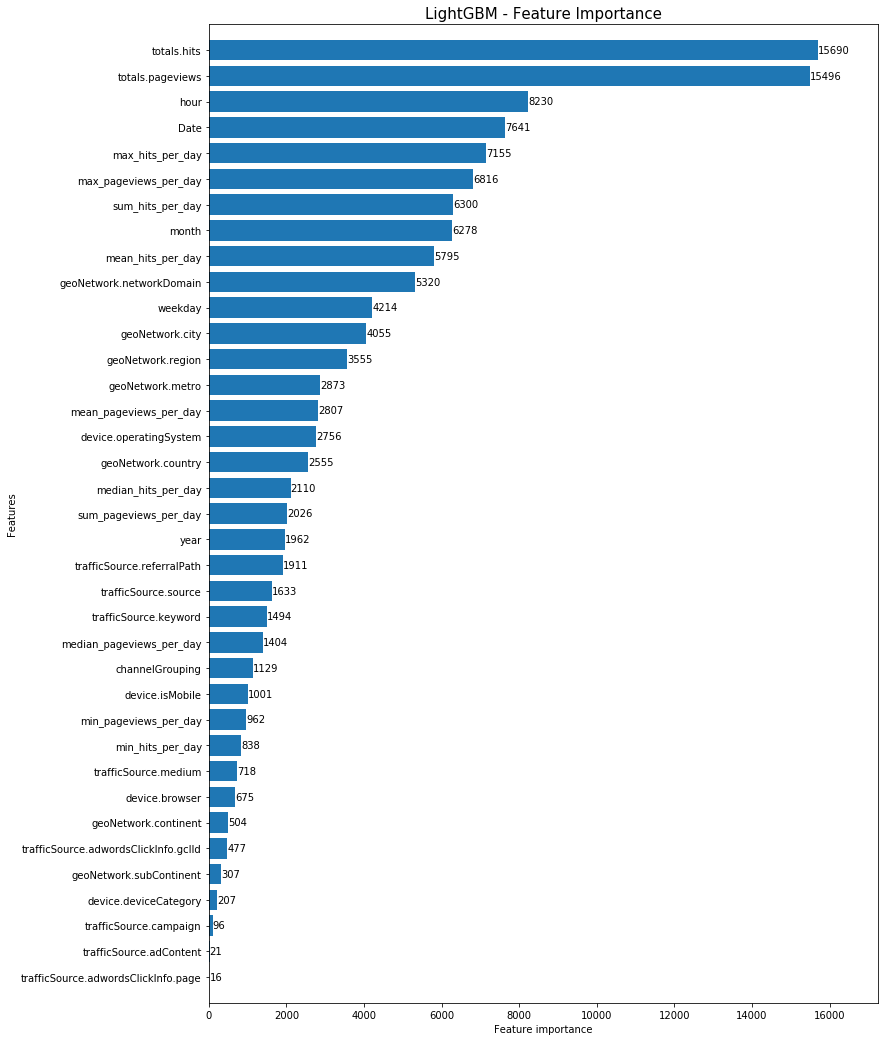

In [490]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(clf, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)

1. Waow! Looks like my engineered features tend to be significantly important for the model.
2. Also total.hits and total.pageviews have the highest feature importance.

<h3>Preparing submission 

In [491]:
#grouping the visitorid and calculating the total predicted revenue- to get total predicted revenue per user
submission = test.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()

In [492]:
submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"]) #storing the logarithmic form of the predicted value

In [493]:
#there are negetive values too.
#as revenue cannot be negetive, converting all negetive values to 0
submission["PredictedLogRevenue"] =  submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)

In [494]:
#saving the predicted result
submission.to_csv("baseline.csv", index=False)

In [495]:
submission.shape

(617242, 2)

In [496]:
submission.head(5)

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.144509
1,0000049363351866189,0.132365
2,0000053049821714864,0.045778
3,0000059488412965267,0.140697
4,0000085840370633780,0.046592
